В комментариях использую английский, т.к. планирую показывать своим англоговорящим коллегам

In [1]:
%pylab inline
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

from scipy import stats
import os, datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import product

Populating the interactive namespace from numpy and matplotlib


In [2]:
esb_hourly = pd.read_csv("esb_hourly.csv", sep = ",", parse_dates=['tpep_pickup_datetime'],
                   index_col = "tpep_pickup_datetime")
#esb_hourly = esb_hourly.drop(columns = "region")

Adding missed rows of time series to datframe and filling it with zeros

In [3]:
time_range = pd.date_range(start="2016-04-01 00:00:00", end = '2016-05-31 23:00:00', freq = 'H' )
tripdata_full = pd.DataFrame()
tripdata_full["tpep_pickup_datetime"] = time_range
tripdata_full["region"] = 1231
tripdata_full["counts"] = 0
tripdata_full = tripdata_full.set_index('tpep_pickup_datetime')
tripdata_full_data = pd.merge_asof(tripdata_full, esb_hourly, on='region', 
                                                               by = ['tpep_pickup_datetime','region'])

tripdata_full_data = tripdata_full_data.fillna(0)
tripdata_full_data = tripdata_full_data.set_index('tpep_pickup_datetime')
esb_hourly = tripdata_full_data.drop(columns = ["counts_x","region"])
esb_hourly.columns = ['counts']
esb_hourly.head()

,counts
tpep_pickup_datetime,
2016-04-01 00:00:00,709
2016-04-01 01:00:00,463
2016-04-01 02:00:00,296
2016-04-01 03:00:00,202
2016-04-01 04:00:00,159


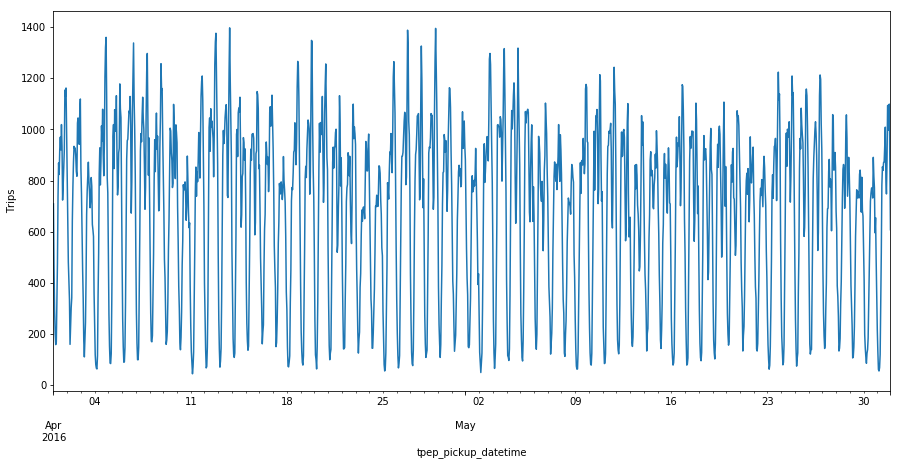

In [4]:
plt.figure(figsize(15,7))
esb_hourly.counts.plot()
plt.ylabel('Trips')
pylab.show()

In [5]:
dt_from = datetime.datetime.strptime("2016-04-01 00:00:00", "%Y-%m-%d %H:%M:%S")
dt_to = datetime.datetime.strptime("2016-05-31 23:00:00", "%Y-%m-%d %H:%M:%S")
esb_hourly_2016 = esb_hourly[(esb_hourly.index <= dt_to) & 
          (esb_hourly.index >= dt_from)]

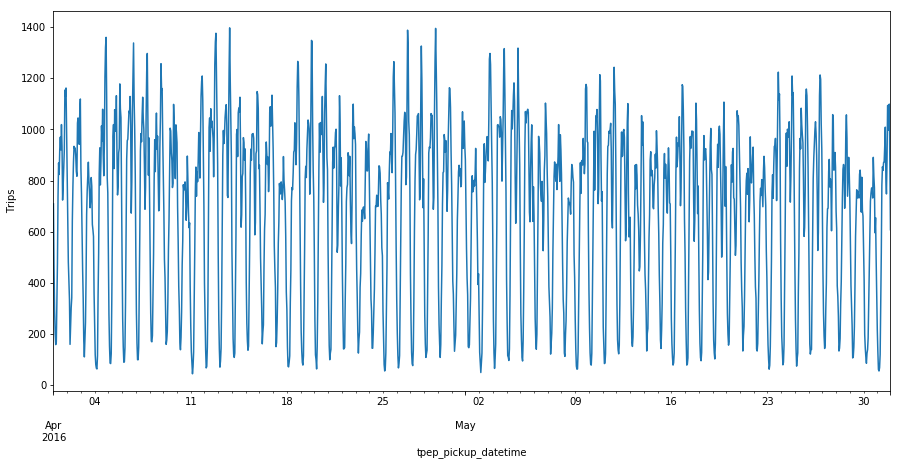

In [6]:
plt.figure(figsize(15,7))
esb_hourly_2016.counts.plot()
plt.ylabel('Trips')
pylab.show()

<Figure size 1080x720 with 0 Axes>

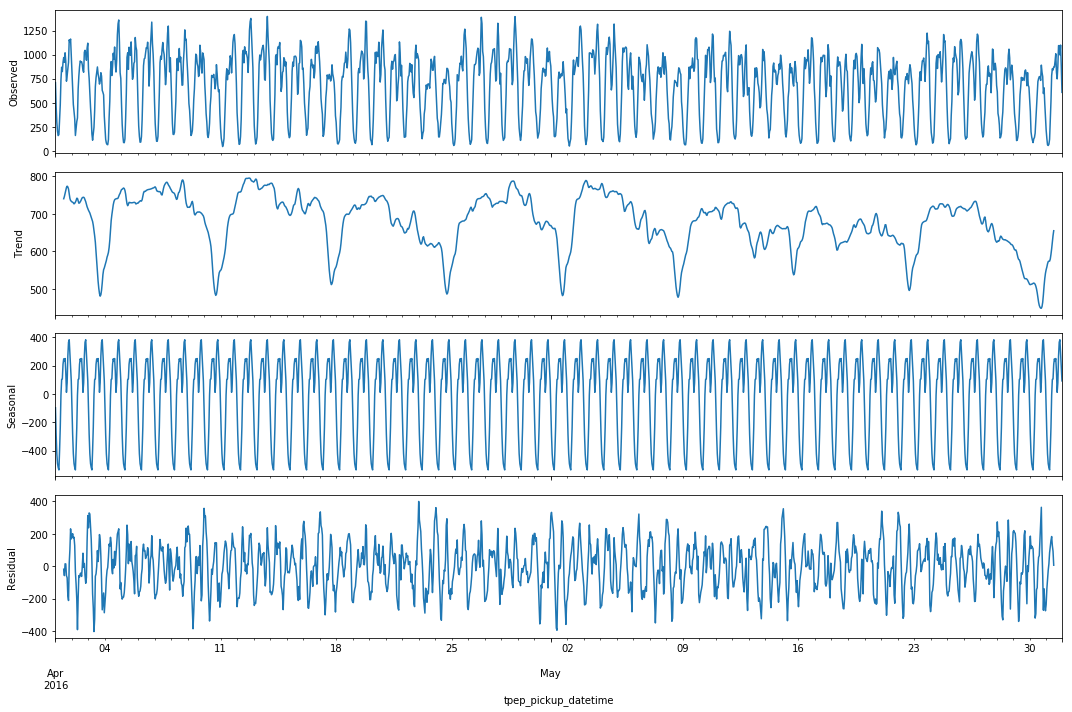

In [7]:
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(esb_hourly_2016['counts'], freq = 24).plot();

<h1>Task 1.

To find the values of the ARIMA hyperparameters, will try to make a series of residues stationary. Let's find out the number of differentiations.

Let's prepare features to describe weekly seasonality
\begin{equation}
s\displaystyle _{i}=\sin([1,...,T]*2\pi i/168),  c\displaystyle _{i}=\cos([1,...,T]*2\pi i/168), i = 1,...,K
\end{equation}

We need to find the K with the least residuals.

In [8]:
mse = []
K = 100
for number in range (1, K + 1):
    temp_data = esb_hourly_2016.copy()
    for i in range(1, number + 1):        
        temp_data['s_' + str(i)] = np.sin(np.arange(1, temp_data.shape[0]+1)*2*np.pi*i/168)
        temp_data['c_' + str(i)] = np.cos(np.arange(1, temp_data.shape[0]+1)*2*np.pi*i/168)
    X = temp_data.loc[:, 's_1':]
    y = temp_data.counts
    m = LinearRegression()
    #We need a try since on some values of K the model will not converge
    try:
        res = m.fit(X, y)
    except LinAlgError:
        mse.append(np.inf)
        print('wrong parameter of K (SVD did not converge in Linear Least Squares):', number)
        continue
    mse.append(mean_squared_error(y, res.predict(X)))
    K_least_mse = np.argmin(mse)
print 'The least MSE is when K =', K_least_mse

('wrong parameter of K (SVD did not converge in Linear Least Squares):', 99)
The least MSE is when K = 99


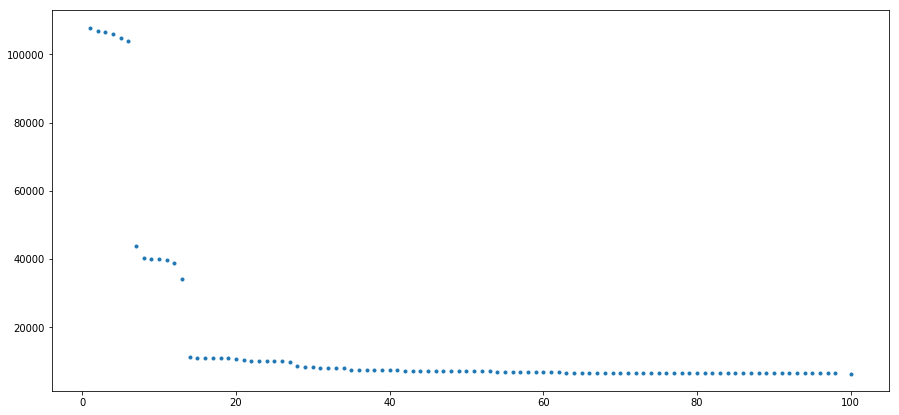

In [9]:
plt.figure(figsize(15, 7))
plt.plot(np.arange(1, K + 1), mse, linestyle='None', marker='.')

let's take k = 35 since after that mse falls not significantly

In [10]:
K_least_mse = 35

In [11]:
for i in range(1, K_least_mse+1):        
        esb_hourly_2016['s_'+str(i)] = np.sin(np.arange(1, esb_hourly_2016.shape[0]+1)*2*np.pi*i/168)
        esb_hourly_2016['c_'+str(i)] = np.cos(np.arange(1, esb_hourly_2016.shape[0]+1)*2*np.pi*i/168)

<h1>Task 2.

In order to roughly choose the order of differentiation of the series in the ARIMA model, we will make a regression of the target feature (the number of trips) by the created features. And let's look at the residuals of the regression.

In [12]:
esb_hourly_2016.head()

,counts,s_1,c_1,s_2,c_2,s_3,c_3,s_4,c_4,s_5,...,s_31,c_31,s_32,c_32,s_33,c_33,s_34,c_34,s_35,c_35
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-04-01 00:00:00,709,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,...,0.916562,0.399892,0.930874,0.365341,0.943883,0.330279,0.955573,0.294755,0.965926,0.258819
2016-04-01 01:00:00,463,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,...,0.733052,-0.680173,0.680173,-0.733052,0.623490,-0.781831,0.563320,-0.826239,0.500000,-0.866025
2016-04-01 02:00:00,296,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,0.532032,...,-0.330279,-0.943883,-0.433884,-0.900969,-0.532032,-0.846724,-0.623490,-0.781831,-0.707107,-0.707107
2016-04-01 03:00:00,202,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239,0.680173,...,-0.997204,-0.074730,-0.997204,0.074730,-0.974928,0.222521,-0.930874,0.365341,-0.866025,0.500000
2016-04-01 04:00:00,159,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,0.733052,0.804598,...,-0.467269,0.884115,-0.294755,0.955573,-0.111964,0.993712,0.074730,0.997204,0.258819,0.965926


In [13]:
X = esb_hourly_2016.loc[:, 's_1':]
y = esb_hourly_2016.counts

linear_model = LinearRegression()
model_fit = linear_model.fit(X, y)
y_predicted = model_fit.predict(X)

esb_hourly_2016['prediction'] = y_predicted
esb_hourly_2016['residuals'] = y - y_predicted

In [14]:
model_fit.score(X, y)

0.9331838418103164

In [15]:
esb_hourly_2016.head()

,counts,s_1,c_1,s_2,c_2,s_3,c_3,s_4,c_4,s_5,...,s_32,c_32,s_33,c_33,s_34,c_34,s_35,c_35,prediction,residuals
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-04-01 00:00:00,709,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,...,0.930874,0.365341,0.943883,0.330279,0.955573,0.294755,0.965926,0.258819,672.574240,36.425760
2016-04-01 01:00:00,463,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,...,0.680173,-0.733052,0.623490,-0.781831,0.563320,-0.826239,0.500000,-0.866025,481.752589,-18.752589
2016-04-01 02:00:00,296,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,0.532032,...,-0.433884,-0.900969,-0.532032,-0.846724,-0.623490,-0.781831,-0.707107,-0.707107,281.593551,14.406449
2016-04-01 03:00:00,202,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239,0.680173,...,-0.997204,0.074730,-0.974928,0.222521,-0.930874,0.365341,-0.866025,0.500000,153.936113,48.063887
2016-04-01 04:00:00,159,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,0.733052,0.804598,...,-0.294755,0.955573,-0.111964,0.993712,0.074730,0.997204,0.258819,0.965926,130.348345,28.651655


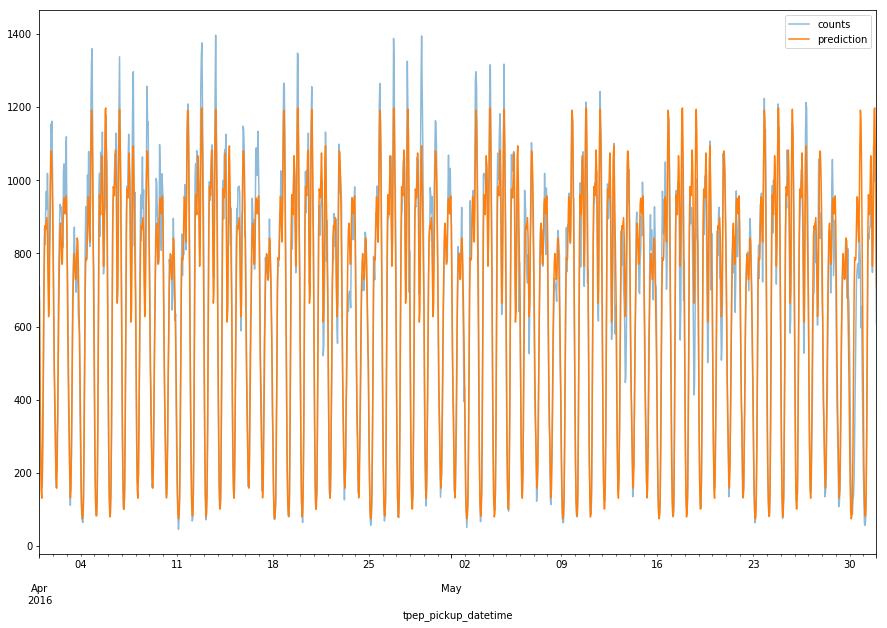

In [16]:
plt.figure(figsize(15, 10))
esb_hourly_2016.counts.plot(alpha = 0.5, legend = True)
esb_hourly_2016.prediction.plot(legend = True)

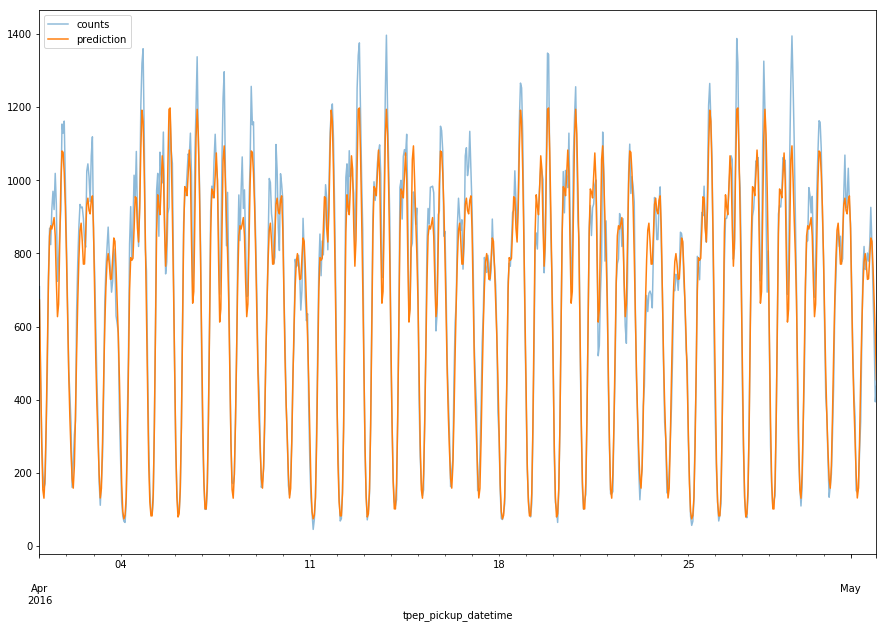

In [17]:
plt.figure(figsize(15, 10))
esb_hourly_2016.loc['2016-04-01':'2016-05-01','counts'].plot(alpha = 0.5, legend = True)
esb_hourly_2016.loc['2016-04-01':'2016-05-01','prediction'].plot(legend = True)

<h1>Task 3.

STL for residuals

<Figure size 1080x720 with 0 Axes>

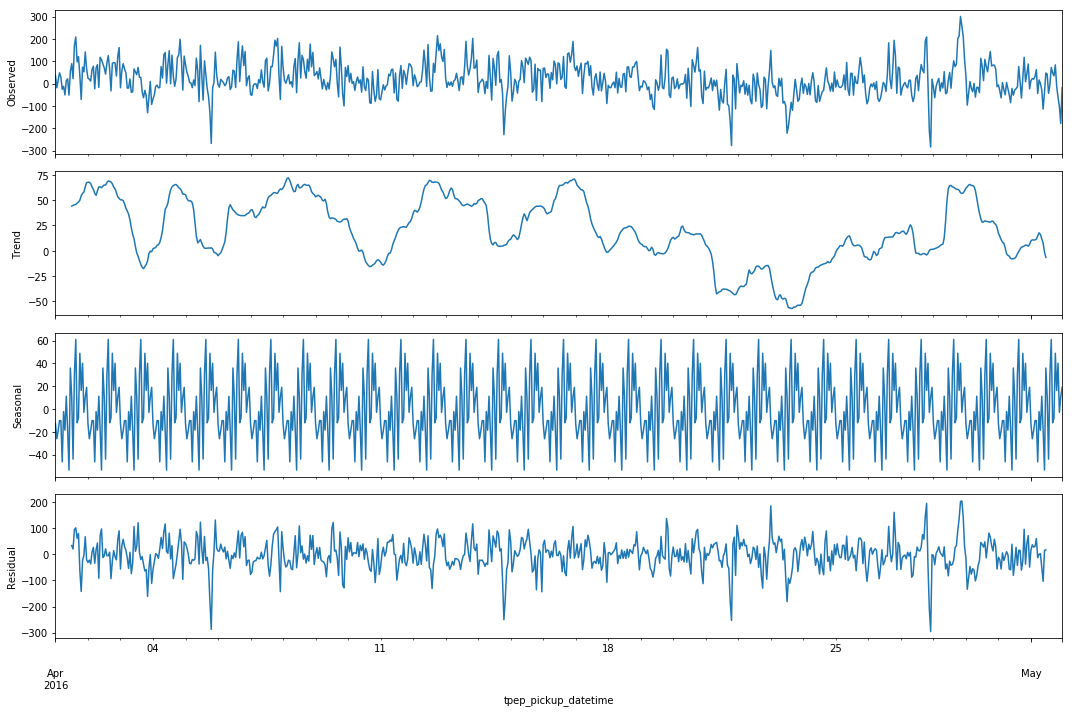

In [18]:
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(esb_hourly_2016.loc['2016-04-01':'2016-05-01','residuals'], freq = 24).plot();

Let's check if our timeseries of residuals is stationary

In [19]:
print "Dickey - Fuller test: p = ", sm.tsa.stattools.adfuller(esb_hourly_2016.counts)[1]

Dickey - Fuller test: p =  7.397058436633976e-07


Dickey - Fuller reject hypothesis about non-stationaity, but from STL we can see the trend. Let's differentiate residuals using weekly shift

<Figure size 1080x720 with 0 Axes>

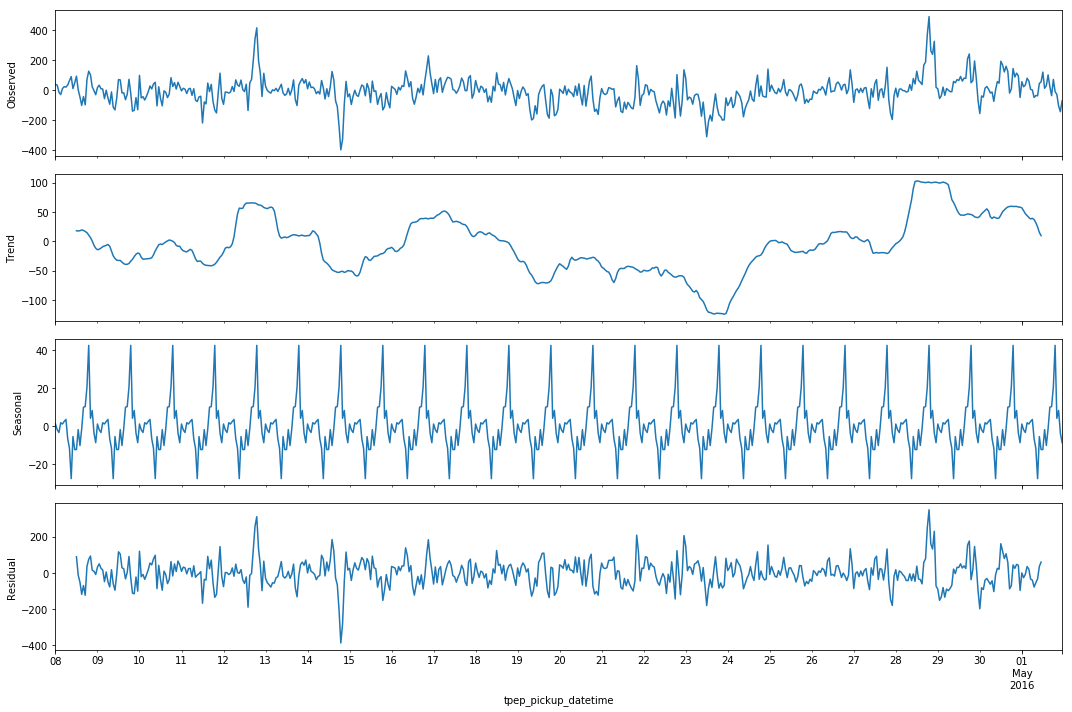

In [20]:
esb_hourly_2016['residuals_dif'] = esb_hourly_2016.residuals-esb_hourly_2016.residuals.shift(168)
#plot_sd(residuals.remains_dif[168:])
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(esb_hourly_2016[168:].loc['2016-04-01':'2016-05-01', 'residuals_dif'], freq = 24).plot();

Trend still exists. Let's differentiate with 1 hr shift

<Figure size 1080x720 with 0 Axes>

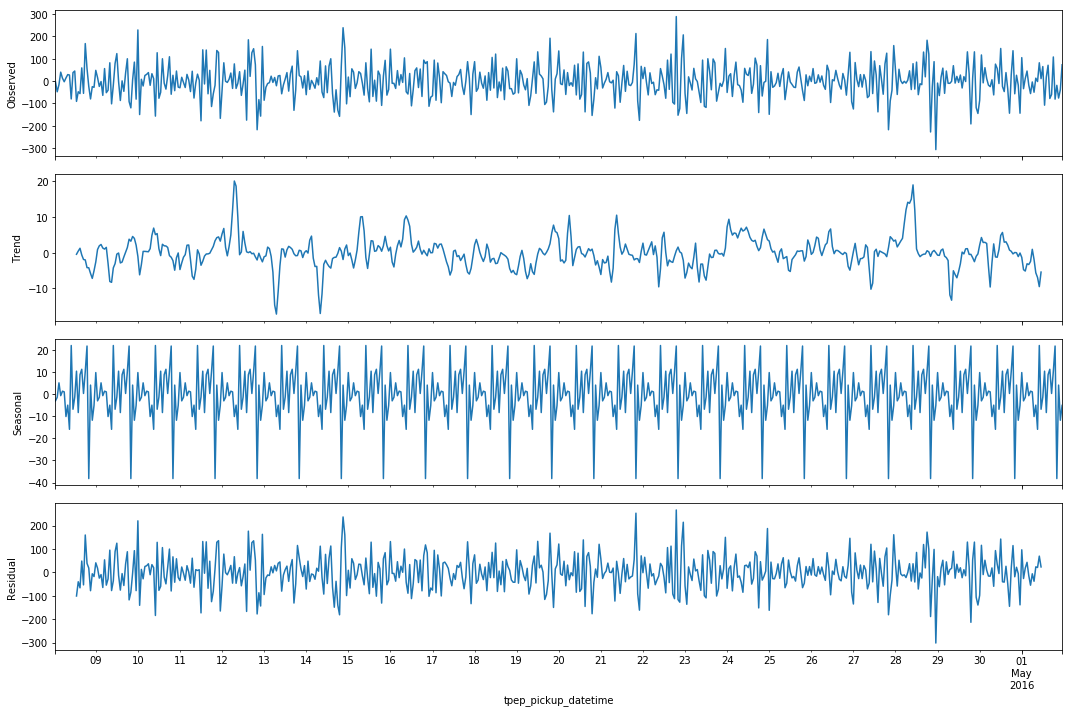

In [21]:
esb_hourly_2016['residuals_dif2'] = esb_hourly_2016.residuals_dif-esb_hourly_2016.residuals_dif.shift(1)
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(esb_hourly_2016[169:].loc['2016-04-01':'2016-05-01', 'residuals_dif2'], freq = 24).plot();

In [22]:
print("Dickey - Fuller test: p = ", sm.tsa.stattools.adfuller(esb_hourly_2016.residuals_dif2[169:])[1])

('Dickey - Fuller test: p = ', 2.564808329552051e-25)


The nonstationarity hypothesis can be rejected, so assuming that the time series is stationary. 

<h1> Task 4

Trying to adjust hyperparams for ARIMA

To see what happens with p and q

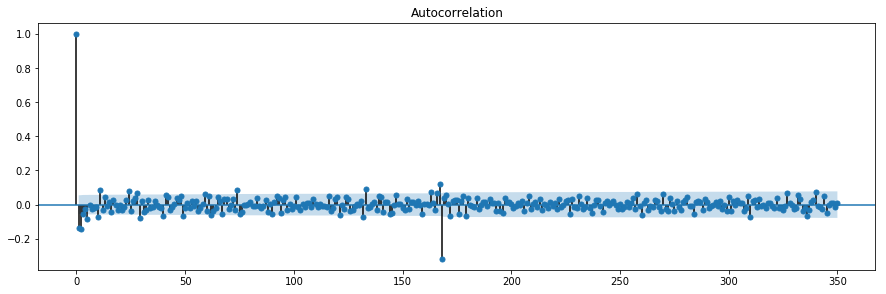

/anaconda2/lib/python2.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


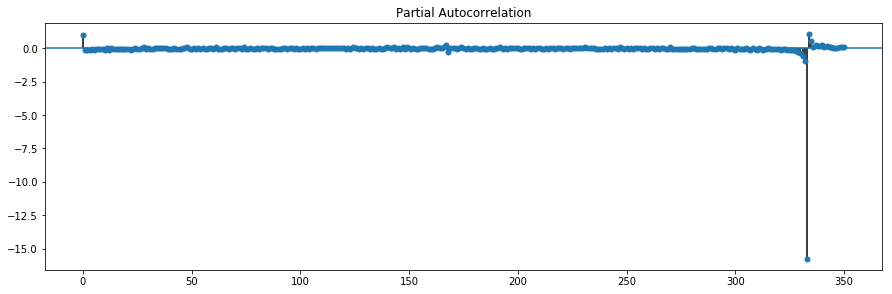

In [23]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(esb_hourly_2016.residuals_dif2[169:].values.squeeze(), lags = 350, ax = ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(esb_hourly_2016.residuals_dif2[169:].values.squeeze(), lags = 350, ax = ax)
plt.show()

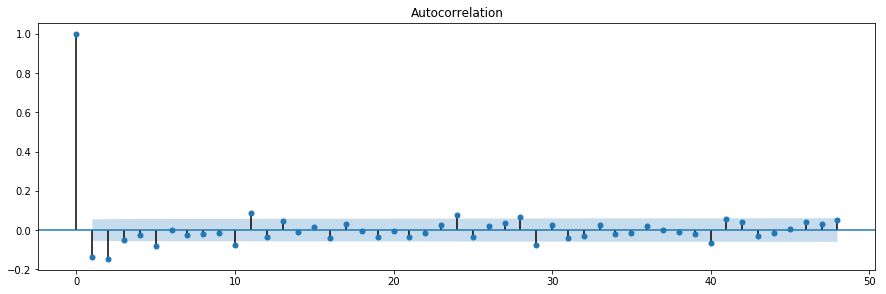

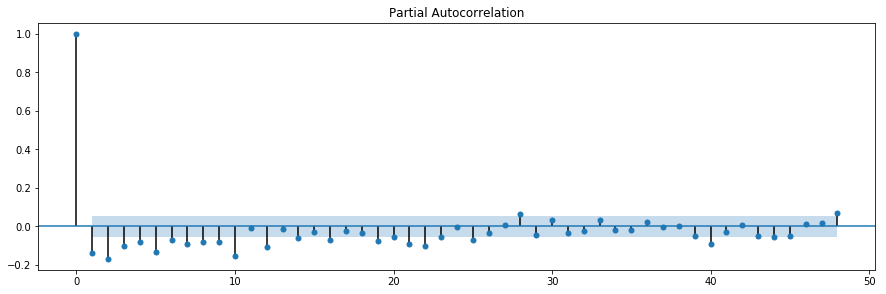

In [24]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(esb_hourly_2016.residuals_dif2[169:].values.squeeze(), lags = 48, ax = ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(esb_hourly_2016.residuals_dif2[169:].values.squeeze(), lags = 48, ax = ax)
plt.show()

Initial approximation: Q = 2 q = 2 P = 1 p = 10

In [25]:
ps = range(0, 11)
d = 0
qs = range(0, 3)
Ps = range(0, 2)
D = 0
Qs = range(0, 3)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

198

Нижеприведенный блок описывывает как я искал оптимальные параметры, выплнение его опущу и не советую его выполнять (т.к очень долго), покажу только ниже отобранный параметры и лучшую модель

In [ ]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')


for param in parameters_list:
    #we need try except since the model will not not fit on some parameter sets
    try:
        model=sm.tsa.statespace.SARIMAX(endog=esb_hourly_2016.counts, 
                                        exog = asarray(esb_hourly_2016.loc[:, 's_1':'s_35']),
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24), 
                                        initialization='approximate_diffuse',
                                        enforce_stationarity=False,
                                        enforce_invertibility=False
                                       ).fit(disp=False)
    #вdisplay parameters on which the model didn't fit and proceed to the next set
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    print 'parameters:{} have aic value {}'.format(param, aic)
    #saving the best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True))

Best params and best model

In [28]:
param = (2, 1, 1, 1)
best_model=sm.tsa.statespace.SARIMAX(endog=esb_hourly_2016.counts, 
                                        exog = asarray(esb_hourly_2016.loc[:, 's_1':'s_35']),
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24), 
                                        initialization='approximate_diffuse',
                                        enforce_stationarity=False,
                                        enforce_invertibility=False
                                       ).fit(disp=False)

<h1> Task 5

Let's look at the best ARIMA model

In [29]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             counts   No. Observations:                 1464
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 24)   Log Likelihood               -8017.265
Date:                            Sat, 29 Jun 2019   AIC                          16184.531
Time:                                    21:06:48   BIC                          16579.857
Sample:                                04-01-2016   HQIC                         16332.115
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -18.7139     17.728     -1.056      0.291     -53.461      16.033
x2            15.2849     18.964   

<h1> Task 6

Let's analyze the model

Критерий Стьюдента: p=0.263569
Критерий Дики-Фуллера: p=0.000000


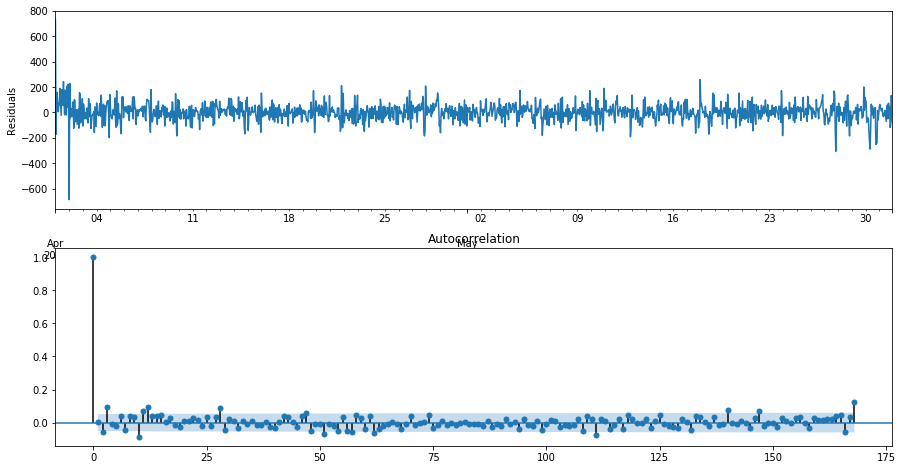

In [30]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=168, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

In [31]:
mean_resid = np.abs(best_model.resid.values.mean())
print mean_resid

2.03091434582736


Критерий Стьюдента: p=0.025446
Критерий Дики-Фуллера: p=0.000000


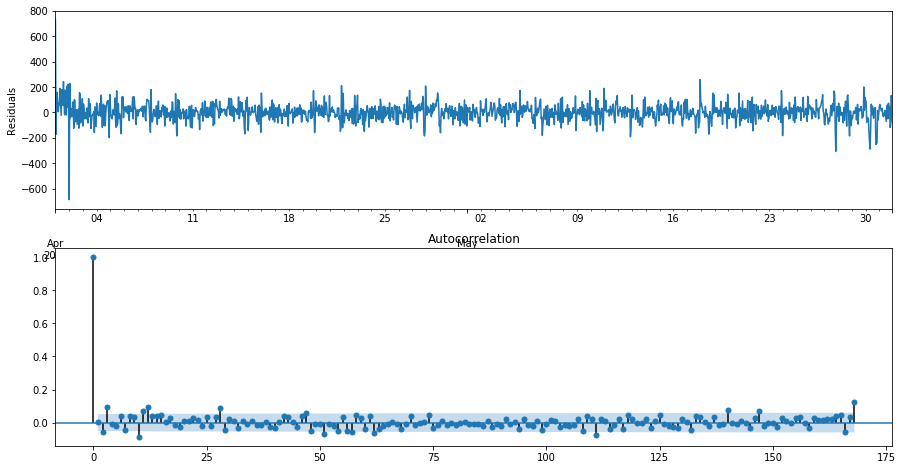

In [32]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze() + mean_resid , lags=168, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid + mean_resid , 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid + mean_resid)[1])

In [33]:
esb_hourly_2016['model'] = best_model.fittedvalues + mean_resid

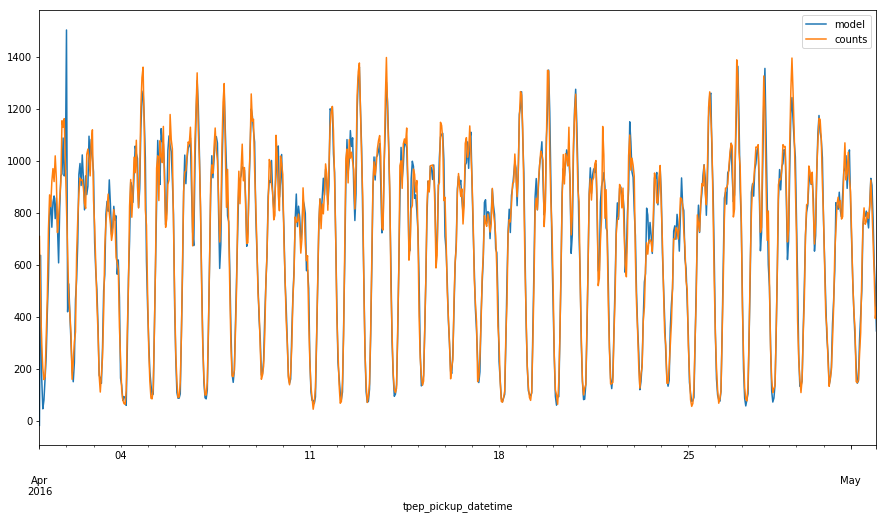

In [34]:
esb_hourly_2016.loc['2016-04-01':'2016-05-01']['model'].plot()
esb_hourly_2016.loc['2016-04-01':'2016-05-01']['counts'].plot()
legend()

Let's see how our model predicts for June 

In [35]:
esb_june = pd.read_csv("esb_june.csv", sep = ",", parse_dates=['tpep_pickup_datetime'],
                   index_col = "tpep_pickup_datetime")

temp_data = esb_june.copy()
for i in range(1, 36):        
    temp_data['s_' + str(i)] = np.sin(np.arange(1, temp_data.shape[0]+1)*2*np.pi*i/168)
    temp_data['c_' + str(i)] = np.cos(np.arange(1, temp_data.shape[0]+1)*2*np.pi*i/168)


esb_june = temp_data


X_june = esb_june.loc[:, 's_1':'s_35']
y_june = esb_june.counts 

for x in range(0,7):
    day_feature = np.array([1 if i.dayofweek == x else 0 for i in esb_june.index])
    X_june = np.concatenate((X_june, day_feature.reshape(X_june.shape[0],1)),axis=1)


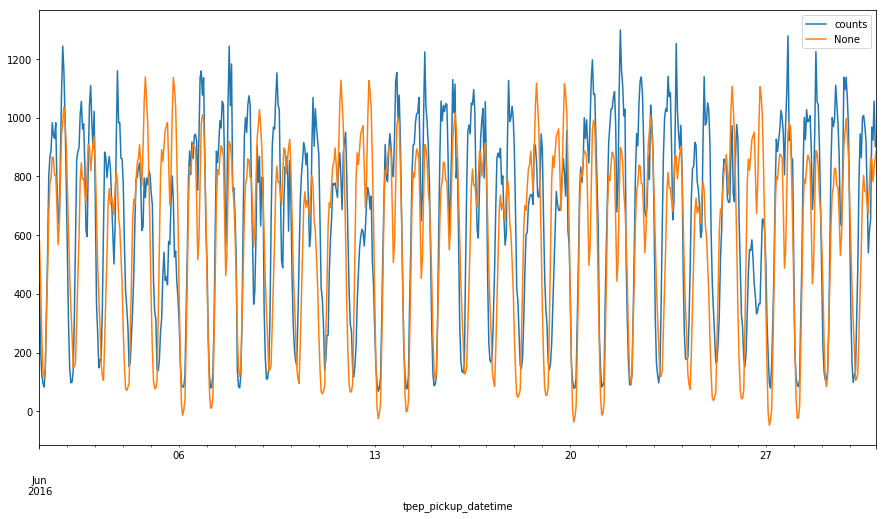

In [38]:
pred = best_model.predict(start=datetime.datetime(2016, 6, 1), end=datetime.datetime(2016, 6, 30, 23, 0), 
                          exog = X_june[:,:-7])
esb_june.counts.plot()
pred.plot()
legend()

In general predicted data looks realistic. The only problem is not accurate predictions on weekends.<br>
Let's try to add week days and maybe holidays as a features

US holidays in 2016

In [39]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
calendar().holidays(start='2016-01-01', end='2016-06-30')

DatetimeIndex(['2016-01-01', '2016-01-18', '2016-02-15', '2016-05-30'], dtype='datetime64[ns]', freq=None)

<h4>It doesn't make sense to add holidays since as we can see we have only one holiday within train period, so our model won't be able to use that data.

In [40]:
X = esb_hourly_2016.loc[:, 's_1':'s_35']
y = esb_hourly_2016.counts 

for x in range(0,7):
    day_feature = np.array([1 if i.dayofweek == x else 0 for i in esb_hourly_2016.index])
    X = np.concatenate((X, day_feature.reshape(X.shape[0],1)),axis=1)
        

In [41]:
linear_model_new = LinearRegression()
model_new_fit = linear_model_new.fit(X, y)
y_predicted_new = model_new_fit.predict(X)

esb_hourly_2016['prediction_new'] = y_predicted_new
esb_hourly_2016['residuals_new'] = y - y_predicted

In [42]:
model_new_fit.score(X, y)

0.9279443604385922

In [43]:
param = (2, 1, 1, 1)
best_model_new = sm.tsa.statespace.SARIMAX(endog=esb_hourly_2016.counts, 
                                        exog = X,
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False
                                       ).fit(disp=-1)

In [44]:
print(best_model_new.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             counts   No. Observations:                 1464
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 24)   Log Likelihood               -7969.668
Date:                            Sat, 29 Jun 2019   AIC                          16103.336
Time:                                    21:15:07   BIC                          16535.559
Sample:                                04-01-2016   HQIC                         16264.695
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -50.8386     29.927     -1.699      0.089    -109.494       7.817
x2            68.7652     29.049   

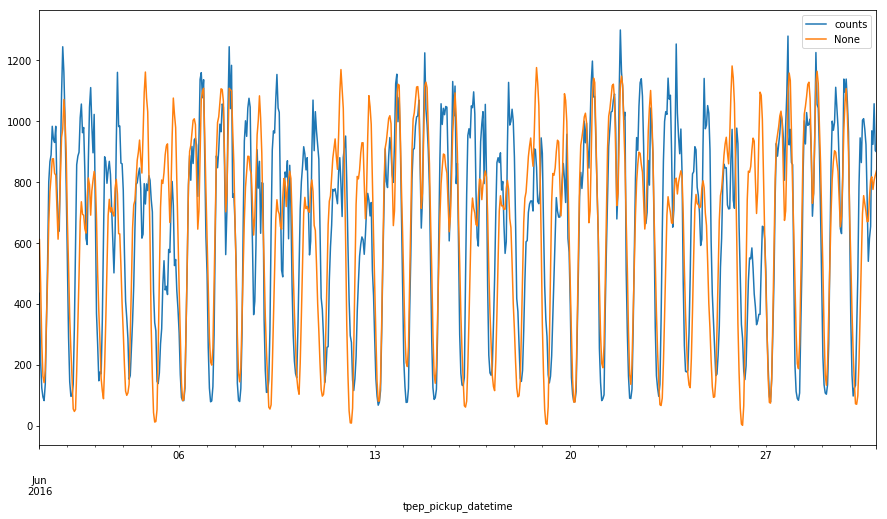

In [46]:
pred = best_model_new.predict(start=datetime.datetime(2016, 6, 1), 
                          end=datetime.datetime(2016, 6, 30, 23, 0), exog = X_june)
esb_june.counts.plot()
pred.plot()
legend()

Выводы:
- Модель неплохо описывает данные
- Добавление фичи дня недели не особо улучшило результаты. Во всяком случае если судить визуально и по критерию акаике. 16103.336 vs 16184.531 не бог весь какой результат, особенно если учитывать, что тестовая выборка в два раза меньше обучающей
- Предсказание в выходные дни все так же можно улучшить, вопрос - как. Я читал что у фб есть либа prophet, которая хорошо учитывает праздники, выходные и т.д.